In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import glob
import math
from skimage.feature import corner_harris,corner_peaks
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
%matplotlib inline

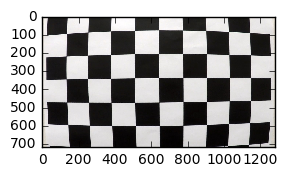

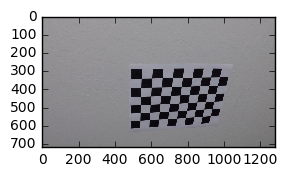

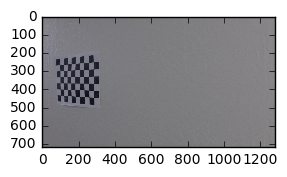

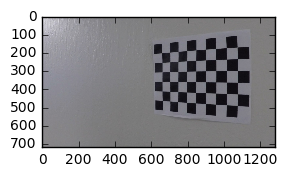

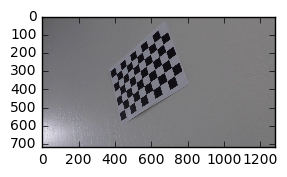

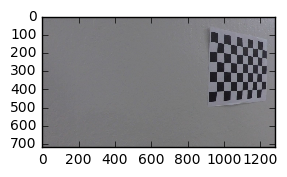

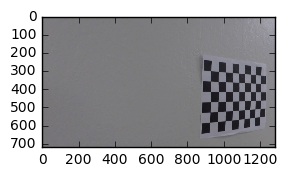

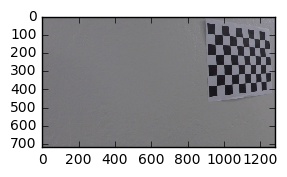

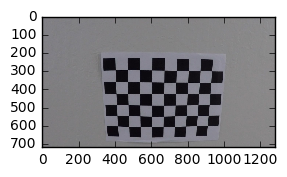

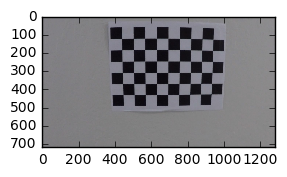

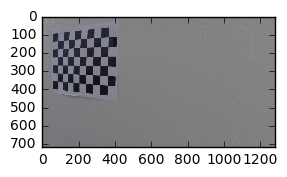

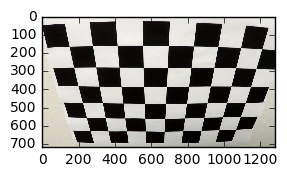

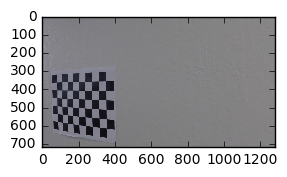

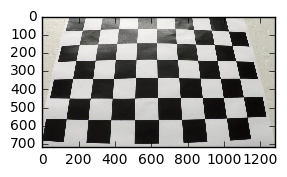

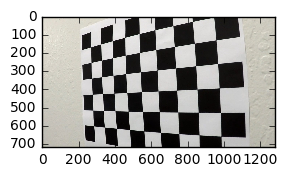

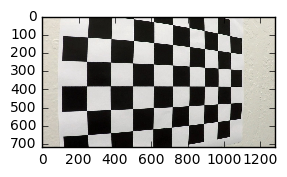

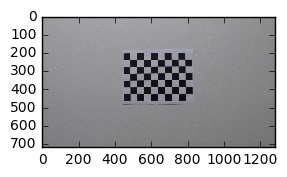

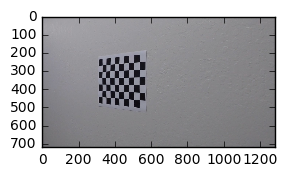

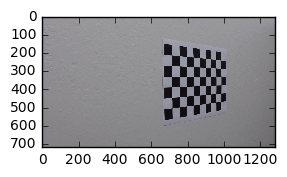

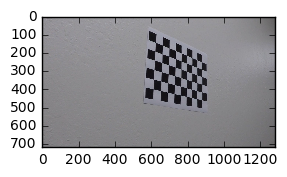

In [2]:
import os
cal_img = []
for filename in os.listdir("camera_cal/"):
    img = mpimg.imread(os.path.join('camera_cal',filename))
    cal_img.append(img)

for img in cal_img:
    plt.figure(figsize=(3, 3))
    plt.imshow(img)

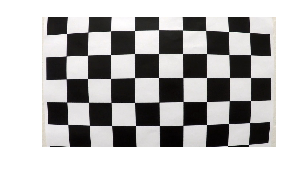

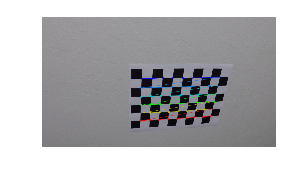

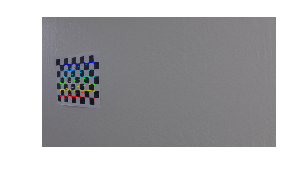

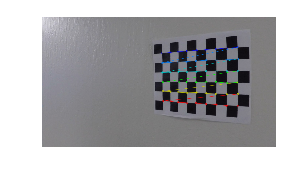

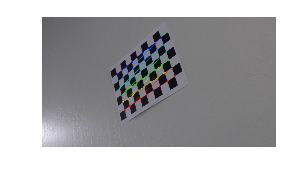

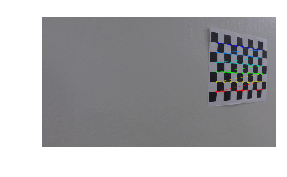

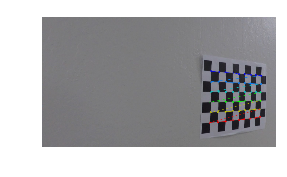

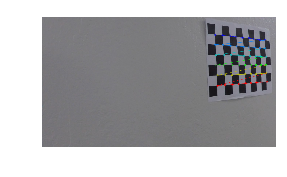

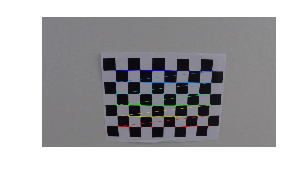

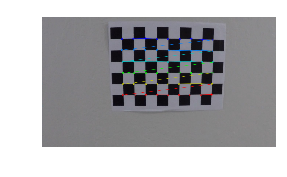

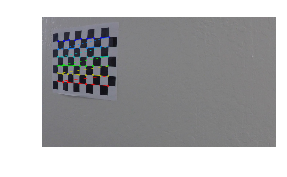

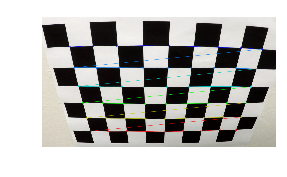

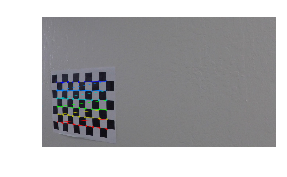

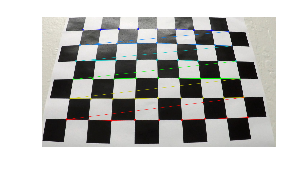

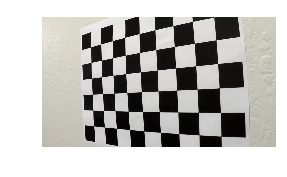

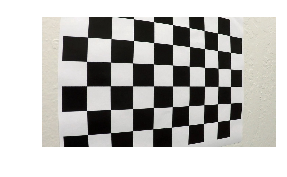

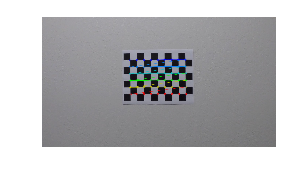

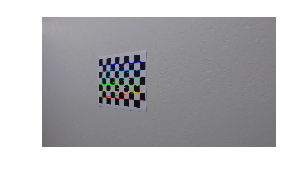

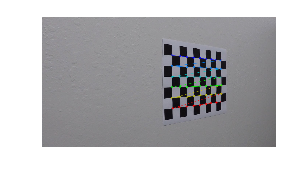

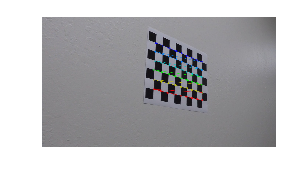

In [3]:
nx = 9
ny = 6

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []

for img in cal_img:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        
for img in cal_img:
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')

In [4]:
img = cal_img[5]
img_size = (img.shape[1], img.shape[0])
img_size

(1280, 720)

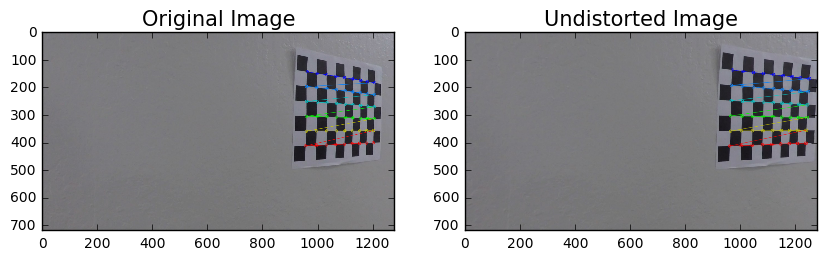

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

data = [mtx, dist]

undst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 15)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize = 15)

In [ ]:
for img in cal_img:
    undst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize = 15)
    ax2.imshow(undst)
    ax2.set_title('Undistorted Image', fontsize = 15)

In [6]:
ksize = 3

In [18]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def abs_sobel_thresh(img, orient = 'x', sobel_kernel=ksize, thresh=(0, 255)):
    img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel >= thresh[1])] = 1
    return grad_binary


def mag_thresh(img, sobel_kernel=ksize, thresh=(0, 255)):
    img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(mag)/255
    scaled_mag = np.uint8(mag/scale_factor)
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernel=ksize, thresh=(0, np.pi/2)):
    img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    return dir_binary

def hsv_select(img, thresh=(0, 255)):
    img = np.copy(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s_channel = hsv[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def undist_f(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def hls_select(img, thresh=(0, 255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def warped(img, M):
    img_size = (img.shape[1], img.shape[0])
    warp_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warp_img


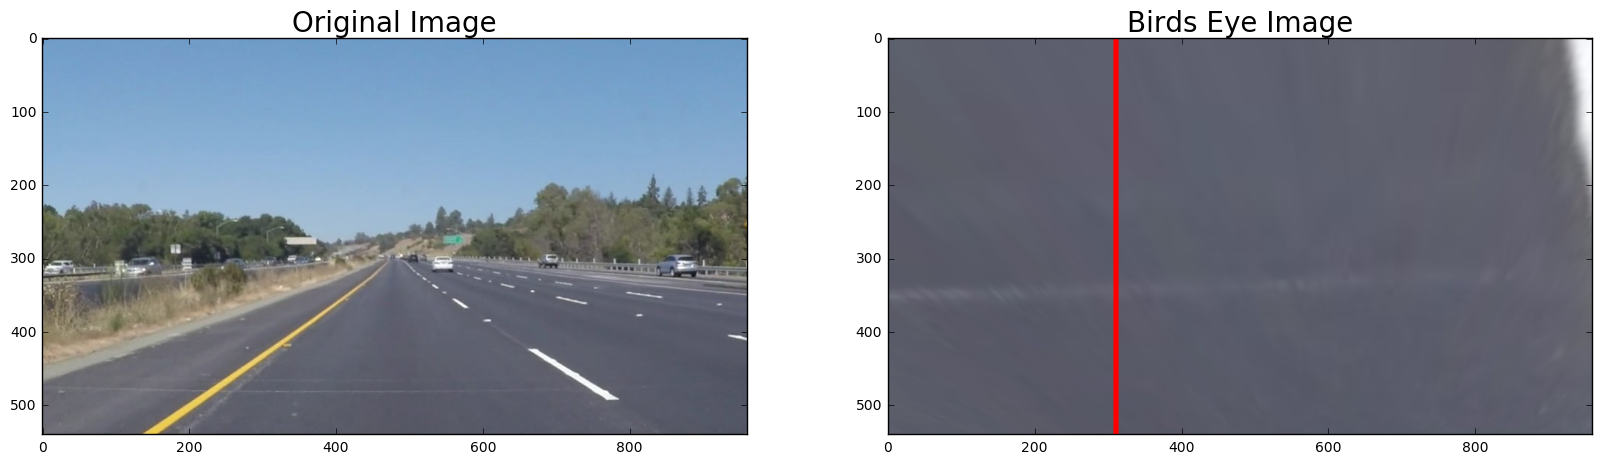

In [22]:
# Define source and destination points for the perspective transform 
src = np.float32([[596, 450], [210, 719], [1100, 719], [685, 450]])
dst = np.float32([[310, 120], [310, 719], [1000, 719], [1000, 120]])

img = cv2.imread('test_images/solidYellowLeft.jpg')
undist = undist_f(img)

# Create matrices for the transforma nd inverse transform
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warp_img = warped(undist, M)

cv2.polylines(undist, [np.int32(src)], True,(0,0,255),5)
cv2.line(warp_img, (310,0), (310,719), (0,0,255),5)
cv2.line(warp_img, (1000,0), (1000,719), (0,0,255),5)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warp_img = cv2.cvtColor(warp_img, cv2.COLOR_BGR2RGB)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warp_img)
ax2.set_title('Birds Eye Image', fontsize=20)

In [ ]:
def gen_fit(img, start_x, line, win_h=40, win_w=100, margin=50):
    ym_per_pix = 3 / 64  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 640  # meteres per pixel in x dimension

    y_size = img.shape[0]

    if (line.frame_count < 10):
        line.frame_count += 1
        num_stripes = int(y_size / win_h)
        mask = np.zeros_like(img)
        median = start_x
        for i in range(num_stripes):
            y_li = y_size - (i + 1) * win_h
            y_ri = y_li + win_h
            x_li = max(0, (median - win_w))
            x_ri = min(img.shape[1], (median + win_w))
            mask[y_li:y_ri, x_li:x_ri] = np.ones((win_h, x_ri - x_li))
            win = img[y_li:y_ri, x_li:x_ri]
            win_ones = np.where(win == 1)
            if (len(win_ones[1]) > 1):
                median = int(np.median(win_ones[1])) + x_li
            masked_img = cv2.bitwise_and(img, mask)
            masked_ones = np.where(masked_img == 1)
    else:
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        lane_inds = ((nonzerox > (line.fit[0] * (nonzeroy ** 2) + line.fit[1] * nonzeroy + line.fit[2] - margin)) & \
                     (nonzerox < (line.fit[0] * (nonzeroy ** 2) + line.fit[1] * nonzeroy + line.fit[2] + margin)))
        lanex = nonzerox[lane_inds]
        laney = nonzeroy[lane_inds]
        masked_ones = [laney, lanex]

    if (len(masked_ones[0]) > 5000):
        line.fit = np.polyfit(masked_ones[0], masked_ones[1], 2)
        fit_cr = np.polyfit(masked_ones[0] * ym_per_pix, masked_ones[1] * xm_per_pix, 2)
        line.curv = ((1 + (2 * fit_cr[0] * y_size + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
        line.x = line.fit[0] * y_size ** 2 + line.fit[1] * y_size + line.fit[2]

In [ ]:
def process_image(img):
    global mtx, dist, M, Minv
    global left_line, right_line
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    binary = th_bin(undist)
    warped = warp(binary, M)

    histogram = np.sum(warped[warped.shape[0] / 2:, :], axis=0)

    mid_x = warped.shape[1] / 2
    left_peak = int(np.argmax(histogram[0:mid_x]))
    left_peak_value = int(np.amax(histogram[0:mid_x]))
    right_peak = int(np.argmax(histogram[mid_x:warped.shape[1]]) + mid_x)
    right_peak_value = int(np.amax(histogram[mid_x:warped.shape[1]]))

    left_peak_check = (left_peak > 200) & (left_peak < 500) & (left_peak_value > 30)
    right_peak_check = (right_peak > 900) & (right_peak < 1200) & (right_peak_value > 30)
    peak_delta_check = ((right_peak - left_peak) > 600) & ((right_peak - left_peak) < 900)

    if (left_peak_check & right_peak_check & peak_delta_check):
        gen_fit(warped, left_peak, left_line)
        gen_fit(warped, right_peak, right_line)

    yvals = np.linspace(0, 100, num=101) * 7.2
    left_fitx = left_line.fit[0] * yvals ** 2 + left_line.fit[1] * yvals + left_line.fit[2]
    right_fitx = right_line.fit[0] * yvals ** 2 + right_line.fit[1] * yvals + right_line.fit[2]

    average_curvature = (left_line.curv + right_line.curv) / 2
    average_x = (left_line.x + right_line.x) / 2
    center_dist = abs(average_x - warped.shape[1] / 2) * 3.7 / 640

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, Minv)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    font = cv2.FONT_HERSHEY_COMPLEX
    color = (255, 255, 255)
    cv2.putText(result, "Radius of curvature = {:.0f} m".format(average_curvature), (50, 50), font, 1, color, 2)
    cv2.putText(result, "Distance from center = {:.2f} m".format(center_dist), (50, 90), font, 1, color, 2)

In [ ]:
# Define source and destination points for the perspective transform 
src = np.float32([[596, 450], [210, 719], [1100, 719], [685, 450]])
dst = np.float32([[310, 120], [310, 719], [1000, 719], [1000, 120]])

img = cv2.imread('test_images/solidYellowLeft.jpg.jpg')
undist = undist_f(img)

# Create matrices for the transforma nd inverse transform
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warp_img = warped(undist, M)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warp_img = cv2.cvtColor(warp_img, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warp_img)
ax2.set_title('Birds Eye Image', fontsize=20)